In [1]:
import torch
from model import Encoder, cp_2_key_model, cp_2_k_mask
from config import args
from dataset import Enigma_simulate_c_2_p, Enigma_simulate_cp_2_k_limited, Enigma_simulate_cp_2_k
from torch.utils.data import DataLoader
import math
from torchsummary import summary
from tqdm import tqdm

Copying the compiled weight to regular models

In [2]:
# Load trained model's weights and config
ckpt = torch.load('CP2K_RNN_ENC_ckpt.pt')
ckpt_args = ckpt['args']

# Initialize new model by configs
model = cp_2_k_mask(args=ckpt_args, out_channels=26)
model.to('cuda')
model.eval()

weights = []
for k, v in ckpt['weights'].items():
    weights.append(v)

for idx, (k, v) in enumerate(model.state_dict().items()):
    # Copying weights
    # We have to copying like this, i am so confused
    v *= 0
    v += weights[idx].detach()

Running a mini batch of examples

In [3]:
dataset = Enigma_simulate_cp_2_k_limited(args=args)
dataloader = DataLoader(
        dataset=dataset,
        batch_size=512,
        collate_fn=dataset.collate_fn_padding,
        shuffle=True
    )

for inputs, targets, masks in dataloader:
    inputs, targets, masks = inputs.to('cuda'), targets.to('cuda'), masks.to('cuda')


    outputs = model(inputs, masks)

    print(f"Input shape: {inputs.shape}\nTarget shape: {targets.shape}\nMask shape: {masks.shape}\nOutput shape: {outputs.shape}")
    # print(masks, targets[1][~masks.T].shape, outputs[1][~masks.T].shape)
    break

true_positive = 0
samples = 0

outputs_indices = torch.argmax(outputs, dim=-1) # -> [rotor, seq, batch]
for rotor in range(outputs_indices.shape[0]):
    mask = outputs_indices[rotor][~masks.T] == targets[rotor][~masks.T]
    true_positive += mask.sum()
    samples += math.prod(mask.shape)

print(f"Acc: {true_positive / samples}")

Input shape: torch.Size([30, 512, 52])
Target shape: torch.Size([3, 30, 512])
Mask shape: torch.Size([512, 30])
Output shape: torch.Size([3, 30, 512, 26])
Acc: 0.9991536736488342


In [4]:
# Make prediction based on user's inputs
inputs, masks = dataset.cipher_plain_text_2_tensor('VMPDTAJYTXDZNEFOSOTPJOYSMOEBNX', 'WEARETHECHAMPIONANDTHEBESTPLAY') # Predict on usr inputs
inputs, masks = inputs.to('cuda'), masks.to('cuda')

with torch.no_grad():
    outputs = model(inputs, masks).argmax(dim=-1).squeeze(-1) # -> shape [rotor, seq]
print(f"Prediction: {chr(ord('A') + outputs[0, 0])}"
      f"{chr(ord('A') + outputs[1, 0])}"
      f"{chr(ord('A') + outputs[2, 0])}")

Prediction: AES


In [5]:
# Testint accuracy in different length
testing_args = args
results = {}


for length in range(5, 6):
    testing_args['SEQ_LENGTH'] = [length, length]
    dataset = Enigma_simulate_cp_2_k_limited(args=testing_args, mode='test')
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=1024,
        collate_fn=dataset.collate_fn_padding,
        shuffle=False,
        drop_last=False
    )

    # Tracking
    true_positive = 0
    samples = 0

    bar = tqdm(dataloader, leave=True)
    bar.set_description_str(f"Length: {length}")

    for inputs, targets, masks in bar:
        inputs, targets, masks = inputs.to('cuda'), targets.to('cuda'), masks.to('cuda')

        # Making prediction
        # with torch.cuda.amp.autocast():
        with torch.no_grad():
            outputs = model(inputs, masks)

            # Compute accuracy
            outputs_indices = torch.argmax(outputs, dim=-1) # -> [rotor, seq, batch]
            for rotor in range(outputs_indices.shape[0]):
                mask = outputs_indices[rotor][~masks.T] == targets[rotor][~masks.T]
                true_positive += mask.sum()
                samples += math.prod(mask.shape)

    # Output and record the result
    results[length] = (true_positive / samples).item()
    print(f"Acc: {true_positive / samples}")

Length: 5: 100%|██████████| 35/35 [00:11<00:00,  2.95it/s]

Acc: 0.07689083367586136


Ploting the results

[5] [0.07689083367586136]


Text(0.5, 0, 'Length')

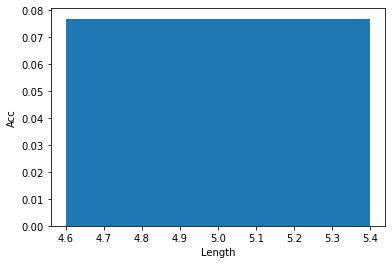

In [6]:
import matplotlib.pyplot as plt
x = list(results.keys())
y = list(results.values())

print(x, y)

fig, ax = plt.subplots()
ax.bar(x,height=y)
ax.set_ylabel('Acc')
ax.set_xlabel('Length')
# ax.plot(bins, y, '--')